# Transfer learning - CNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

(train, test), info = tfds.load("tf_flowers", split=[
    "train[:80%]", "train[80%:]"],
    as_supervised=True, with_info=True)

info


2022-05-04 09:03:27.444881: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2022-05-04 09:03:32.089103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 09:03:32.190661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 09:03:32.191489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 09:03:32.193873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [2]:
label_names = ["dandelion",
               "daisy",
               "tulips",
               "sunflowers",
               "roses"]

train

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

2022-05-04 09:03:44.010243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-04 09:03:44.096884: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


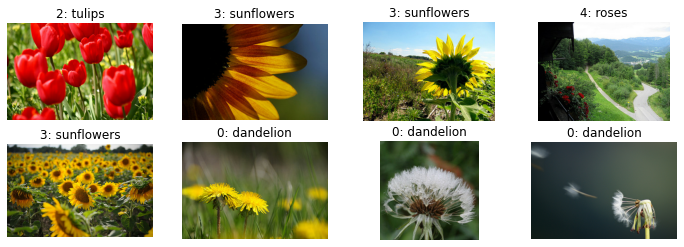

In [3]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
    #print(f"{img_sample[0].shape=}, label: {img_sample[1]}");
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis("off")

## Preprocessing

In [4]:
import tensorflow as tf

def preprocessing(img, label, img_shape=(120, 120)):
    img = tf.image.resize(img, img_shape)/255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

train_batch = train.shuffle(buffer_size=600).map(
    preprocessing).batch(batch_size).prefetch(1)

test_batch = test.map(preprocessing).batch(batch_size).prefetch(1)

train_batch

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int64)>

## Transfer learning

In [5]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(input_shape))

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
______________________________________________________________

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential([
    base_model,
    Flatten(),
    Dropout(.5),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dropout(.5),
    Dense(5, activation="softmax")
], name = "cool_model")

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

model.summary()

Model: "cool_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 15,895,877
Trainable params: 1,181,189
Non-trainable params: 14,714,688
____________________________________

In [9]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
92/92 [==============================] - 3s 28ms/step - loss: 1.2304 - acc: 0.5269 - val_loss: 0.8345 - val_acc: 0.6894
Epoch 2/20
92/92 [==============================] - 2s 26ms/step - loss: 0.8320 - acc: 0.7016 - val_loss: 0.7113 - val_acc: 0.7398
Epoch 3/20
92/92 [==============================] - 2s 27ms/step - loss: 0.7406 - acc: 0.7272 - val_loss: 0.6628 - val_acc: 0.7575
Epoch 4/20
92/92 [==============================] - 2s 26ms/step - loss: 0.6577 - acc: 0.7609 - val_loss: 0.6217 - val_acc: 0.7807
Epoch 5/20
92/92 [==============================] - 2s 26ms/step - loss: 0.6265 - acc: 0.7643 - val_loss: 0.6266 - val_acc: 0.7834
Epoch 6/20
92/92 [==============================] - 3s 28ms/step - loss: 0.5654 - acc: 0.7946 - val_loss: 0.6189 - val_acc: 0.7888
Epoch 7/20
92/92 [==============================] - 2s 26ms/step - loss: 0.5333 - acc: 0.8004 - val_loss: 0.6008 - val_acc: 0.7834
Epoch 8/20
92/92 [==============================] - 2s 26ms/step - loss: 0.5169 - a

In [10]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,1.230361,0.526907,0.834545,0.689373
1,0.831962,0.701635,0.711322,0.739782
2,0.740592,0.727180,0.662766,0.757493
3,0.657704,0.760899,0.621650,0.780654
4,0.626466,0.764305,0.626584,0.783379


<AxesSubplot:>

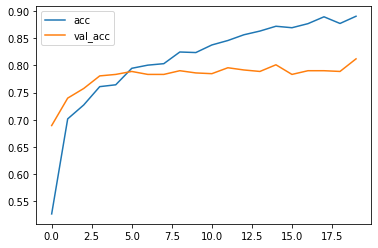

In [11]:
metrics[["acc", "val_acc"]].plot()

<AxesSubplot:>

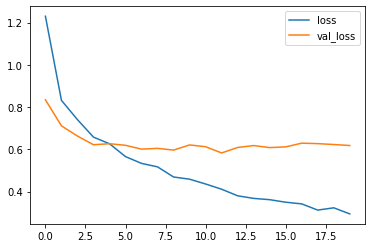

In [12]:
metrics[["loss", "val_loss"]].plot()

## Xception network

In [13]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights="imagenet", include_top=False,
                   input_shape=(input_shape))

base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 59, 59, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 59, 59, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 59, 59, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(.5),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dropout(.5),
    Dense(5, activation="softmax")
], name = "Xception_transfer")

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

model.summary()

Model: "Xception_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 21,387,309
Trainable params: 525,829
Non-trainable params: 20,861,480
_______________________________

In [15]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
92/92 [==============================] - 7s 48ms/step - loss: 0.9788 - acc: 0.6332 - val_loss: 0.5786 - val_acc: 0.8011
Epoch 2/20
92/92 [==============================] - 3s 35ms/step - loss: 0.6651 - acc: 0.7568 - val_loss: 0.5253 - val_acc: 0.8297
Epoch 3/20
92/92 [==============================] - 3s 34ms/step - loss: 0.5913 - acc: 0.7793 - val_loss: 0.4986 - val_acc: 0.8243
Epoch 4/20
92/92 [==============================] - 3s 35ms/step - loss: 0.5266 - acc: 0.8052 - val_loss: 0.4794 - val_acc: 0.8311
Epoch 5/20
92/92 [==============================] - 3s 34ms/step - loss: 0.4791 - acc: 0.8290 - val_loss: 0.4585 - val_acc: 0.8297
Epoch 6/20
92/92 [==============================] - 3s 34ms/step - loss: 0.4575 - acc: 0.8321 - val_loss: 0.4670 - val_acc: 0.8433
Epoch 7/20
92/92 [==============================] - 3s 36ms/step - loss: 0.4037 - acc: 0.8457 - val_loss: 0.4664 - val_acc: 0.8243
Epoch 8/20
92/92 [==============================] - 3s 37ms/step - loss: 0.4026 - a

In [16]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.978850,0.633174,0.578601,0.801090
1,0.665089,0.756812,0.525258,0.829700
2,0.591287,0.779292,0.498564,0.824251
3,0.526572,0.805177,0.479426,0.831063
4,0.479069,0.829019,0.458492,0.829700


<AxesSubplot:>

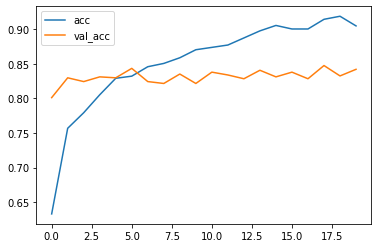

In [18]:
metrics[["acc", "val_acc"]].plot()